# Diabetes Dataset Analysis

### AAEs Analysis

In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from mlp_to_qbaf_converter.mlp_to_qbaf import MLPToQBAF
import Uncertainpy.src.uncertainpy.gradual as grad
from mlp_to_qbaf_converter.argument_attribution_explanation import AAE
from mlp_to_qbaf_converter.relation_attribution_explanation import RAE
from mlp_to_qbaf_converter.utils import plot_qbaf
from tqdm import tqdm
from scipy.stats import kendalltau, spearmanr
import joblib

We have trained MLP Classifers for the Diabetes dataset on various hidden layer sizes. We have then translated to QBAFs and computed the AAE gradient score for each of the above models and different levels of sparification. We have then compared the most important argument (neuron) between the sparsifed and original models, evaluating whether the most important neuron is the same in both models.

The sparsification levels are: 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%

In [2]:
max_argument_mlp_dict = {}
gradient_scores_dict = {}
rankings_dict = {}
removal_impacts_dict = {}


for mlp in Path("../../outputs/diabetes/aae").glob("*_gradient.npz"):

    file_name = mlp.stem
    # mlp_size1_size2_size3..._gradient.npz
    mlp_size = file_name.replace("_gradient","")
    print(mlp_size)

    data = np.load(mlp, allow_pickle=True)

    max_argument_mlp_dict[mlp_size] = data["max_arguments"]
    gradient_scores_dict[mlp_size] = data["top_scores"]
    rankings_dict[mlp_size] = data["rankings"]
    removal_impacts_dict[mlp_size] = data["impacts"]
    

mlp90
mlp3_4
mlp60
mlp45_45
mlp35_35
mlp30
mlp10
mlp30_30_30
mlp40
mlp100_25
mlp20_20
mlp15_15
mlp40_40
mlp30_30
mlp25_100
mlp50
mlp20
mlp25_25
mlp10_10
mlp70
mlp5_5
mlp100
mlp80


In [3]:
shrink_percentages = [10, 20, 30, 40, 50, 60, 70, 80, 90]
header_shrink = [("Shrink", f"{percent}%") for percent in shrink_percentages]
results_df = pd.DataFrame(columns=[("", "Hidden Layers"), ("", "Total No. Neurons"), ("", "Depth")] + header_shrink)
results_df.columns = pd.MultiIndex.from_tuples(results_df.columns)
sizes = []
depths = []
totals = []

for i, mlp in enumerate(max_argument_mlp_dict):
    size = tuple(map(int, str(mlp)[3:].split("_")))
    sizes.append(size)
    depth = len(size)
    depths.append(depth)
    total_neurons = sum(size)
    totals.append(total_neurons)


    results_df.loc[i, ("", "Hidden Layers")] = str(size)
    results_df.loc[i, ("", "Total No. Neurons")] = total_neurons
    results_df.loc[i, ("", "Depth")] = depth

    results_df.loc[i, header_shrink] = max_argument_mlp_dict[mlp]

In [4]:
# from IPython.display import HTML
# HTML(results_df.style.set_table_styles(
#     [{'selector': 'th', 'props': [('text-align', 'center')]}]
# ).to_html(index=False))


results_df

Shrink                        \
   Hidden Layers Total No. Neurons Depth        10%        20%        30%   
0          (90,)                90     1  93.939394  89.177489  87.445887   
1         (3, 4)                 7     2  31.601732  32.467532  34.632035   
2          (60,)                60     1  93.939394  86.580087  82.251082   
3       (45, 45)                90     2    99.5671  98.268398  96.103896   
4       (35, 35)                70     2  97.835498  94.805195  93.073593   
5          (30,)                30     1  96.103896  91.341991  86.580087   
6          (10,)                10     1      100.0  97.835498  96.536797   
7   (30, 30, 30)                90     3  28.571429    9.95671   4.329004   
8          (40,)                40     1  95.238095  92.640693   90.04329   
9      (100, 25)               125     2  95.238095   90.04329  85.714286   
10      (20, 20)                40     2  85.281385   79.65368  76.190476   
11      (15, 15)                30     2  92.640693  88.311688  81.818182   
12      (40, 40)                80     2  97.835498  96.536797  95.670996   
13      (30, 30)                60     2  98.268398  97.402597  95.238095   
14     (25, 100)               125     2    99.5671    99.5671  97.402597   
15         (50,)                50     1  96.536797  91.341991  85.281385   
16         (20,)                20     1  88.744589  86.147186  81.385281   
17      (25, 25)                50     2  95.670996  92.640693  81.818182   
18      (10, 10)                20     2  89.177489  84.848485  78.787879   
19         (70,)                70     1  98.268398  96.969697  93.073593   
20        (5, 5)                10     2   70.12987  69.264069  44.155844   
21        (100,)               100     1    99.5671  98.701299  96.969697   
22         (80,)                80     1  96.103896  92.640693   90.04329   

                                                                      
          40%        50%        60%        70%        80%        90%  
0   81.818182  78.787879  71.861472  67.532468  62.337662  53.679654  
1         0.0        0.0        0.0        0.0        0.0        0.0  
2   76.190476  74.891775  66.666667  59.307359  56.709957   60.17316  
3   93.073593  87.878788  84.415584  72.727273  61.038961  23.809524  
4    89.61039  83.116883   79.65368  75.324675  62.337662   8.658009  
5   83.549784  77.056277  69.264069  59.307359  48.917749  64.069264  
6   94.372294  84.848485  78.354978  81.385281  75.757576      100.0  
7    3.030303   1.731602   2.164502   4.329004  10.822511  18.614719  
8   87.878788  83.982684  80.519481  75.757576  63.203463  50.649351  
9   83.982684  80.952381  75.324675  68.831169  61.038961  38.961039  
10  72.294372  70.995671  64.935065   59.74026  48.484848   4.329004  
11  79.220779  72.727273  66.666667  41.125541  26.406926        0.0  
12  91.341991  86.580087  75.757576  63.636364  52.380952  38.528139  
13   90.04329  86.580087  78.787879  68.398268  51.082251  19.047619  
14  94.372294  89.177489  86.147186  75.757576  56.277056   19.91342  
15  78.787879  74.891775  73.593074  69.264069  67.099567   60.17316  
16  79.220779  72.727273  67.532468  57.575758  40.692641   60.17316  
17  77.489177  68.398268   59.74026   40.25974  12.987013        0.0  
18  73.160173  65.800866  48.051948  35.064935  44.155844        0.0  
19   89.61039  87.012987  82.251082  77.056277  68.831169  53.679654  
20  43.290043  43.290043  41.125541   30.30303   30.30303   30.30303  
21  95.238095  92.207792  87.878788  82.251082  78.787879  63.636364  
22  84.415584  73.160173  67.965368  62.337662  41.125541  24.675325

In [5]:
max_arg_results = []

for shrink_percentage in header_shrink:
    avg = results_df[shrink_percentage].mean()
    max_arg_results.append(avg)
    print(f"Average for {shrink_percentage[1]} Sparsification: {avg.mean()}")

print(f"Latex row: {"&".join([str(round(x, 1)) for x in max_arg_results])} \\\\")


Average for 10% Sparsification: 88.68812347073217
Average for 20% Sparsification: 85.09316770186336
Average for 30% Sparsification: 80.63241106719366
Average for 40% Sparsification: 75.73875399962355
Average for 50% Sparsification: 71.16506681724073
Average for 60% Sparsification: 65.59382646339166
Average for 70% Sparsification: 57.707509881422915
Average for 80% Sparsification: 48.72953133822699
Average for 90% Sparsification: 34.48146056841709
Latex row: 88.7&85.1&80.6&75.7&71.2&65.6&57.7&48.7&34.5 \\


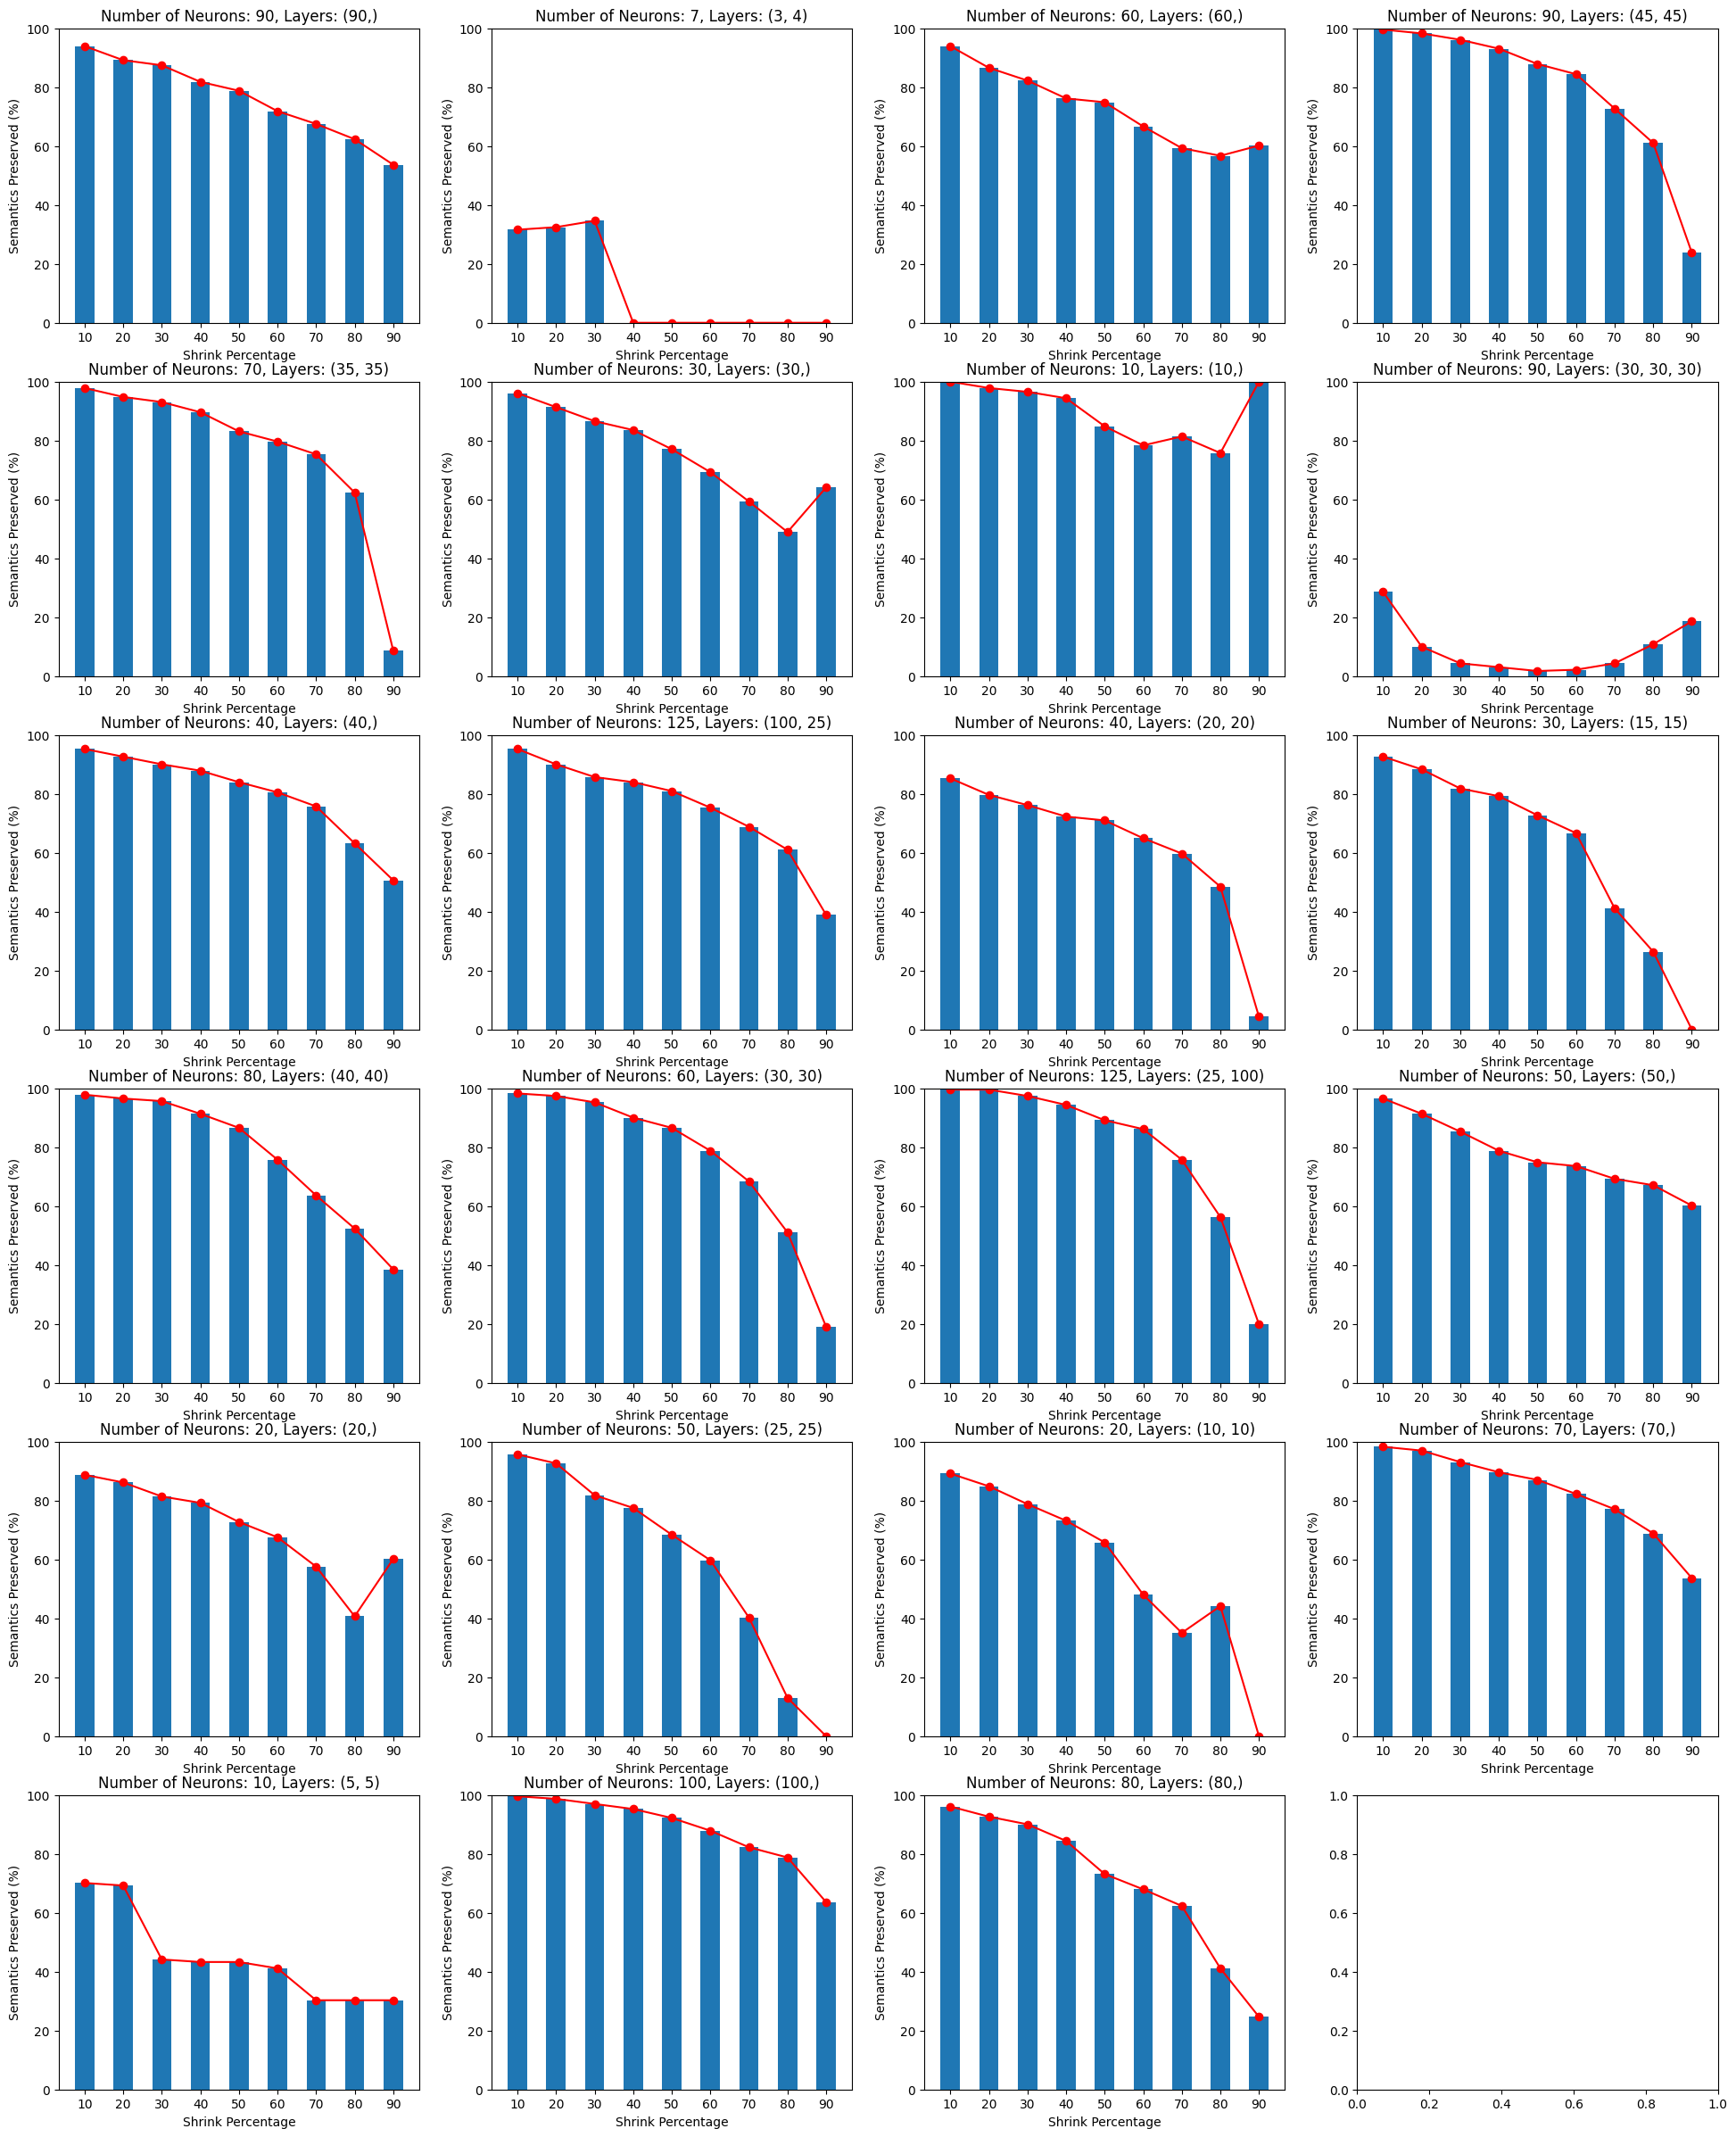

In [ ]:
import math

num_sizes = len(sizes)
cols = min(4, math.ceil(math.sqrt(num_sizes)))
rows = math.ceil(num_sizes / cols)
fig, ax = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))

for i, size in enumerate(sizes):
    ax[i//cols, i%cols].bar(shrink_percentages, results_df.iloc[i, 3:], width=5)
    ax[i//cols, i%cols].plot(shrink_percentages, results_df.iloc[i, 3:], marker="o", color="red")
    ax[i//cols, i%cols].set_title(f"Number of Neurons: {totals[i]}, Layers: {size}")
    ax[i//cols, i%cols].set_xlabel("Shrink Percentage")
    ax[i//cols, i%cols].set_ylabel("Semantics Preserved (%)")
    ax[i//cols, i%cols].set_ylim(0, 100)
    ax[i//cols, i%cols].set_xticks(shrink_percentages)


In [7]:
# depths_unique = np.unique(depths)
# depths_unique_sorted_idx = np.argsort(depths_unique)
# depths_unique = depths_unique[depths_unique_sorted_idx]
# average_preserved_depth = np.zeros((len(depths_unique), len(shrink_percentages)))

# for i, depth in enumerate(depths_unique):
#     average_preserved_depth[i] = np.mean(results_df[results_df[("", "Depth")] == depth].iloc[:, 3:], axis=0)

# rows = math.ceil(math.sqrt(len(depths_unique)))
# cols = math.ceil(len(depths_unique) / rows)
# fig, ax = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))

# for i, depth in enumerate(depths_unique):
#     ax[i//cols, i%cols].bar(shrink_percentages, average_preserved_depth[i], width=5)
#     ax[i//cols, i%cols].plot(shrink_percentages, average_preserved_depth[i], marker="o", color="red")
#     ax[i//cols, i%cols].set_title(f"Depth (Number Hidden Layers): {depth}")
#     ax[i//cols, i%cols].set_xlabel("Shrink Percentage")
#     ax[i//cols, i%cols].set_ylabel("Semantics Preserved Average (%)")
#     ax[i//cols, i%cols].set_ylim(0, 100)
#     ax[i//cols, i%cols].set_xticks(shrink_percentages)

# plt.show()

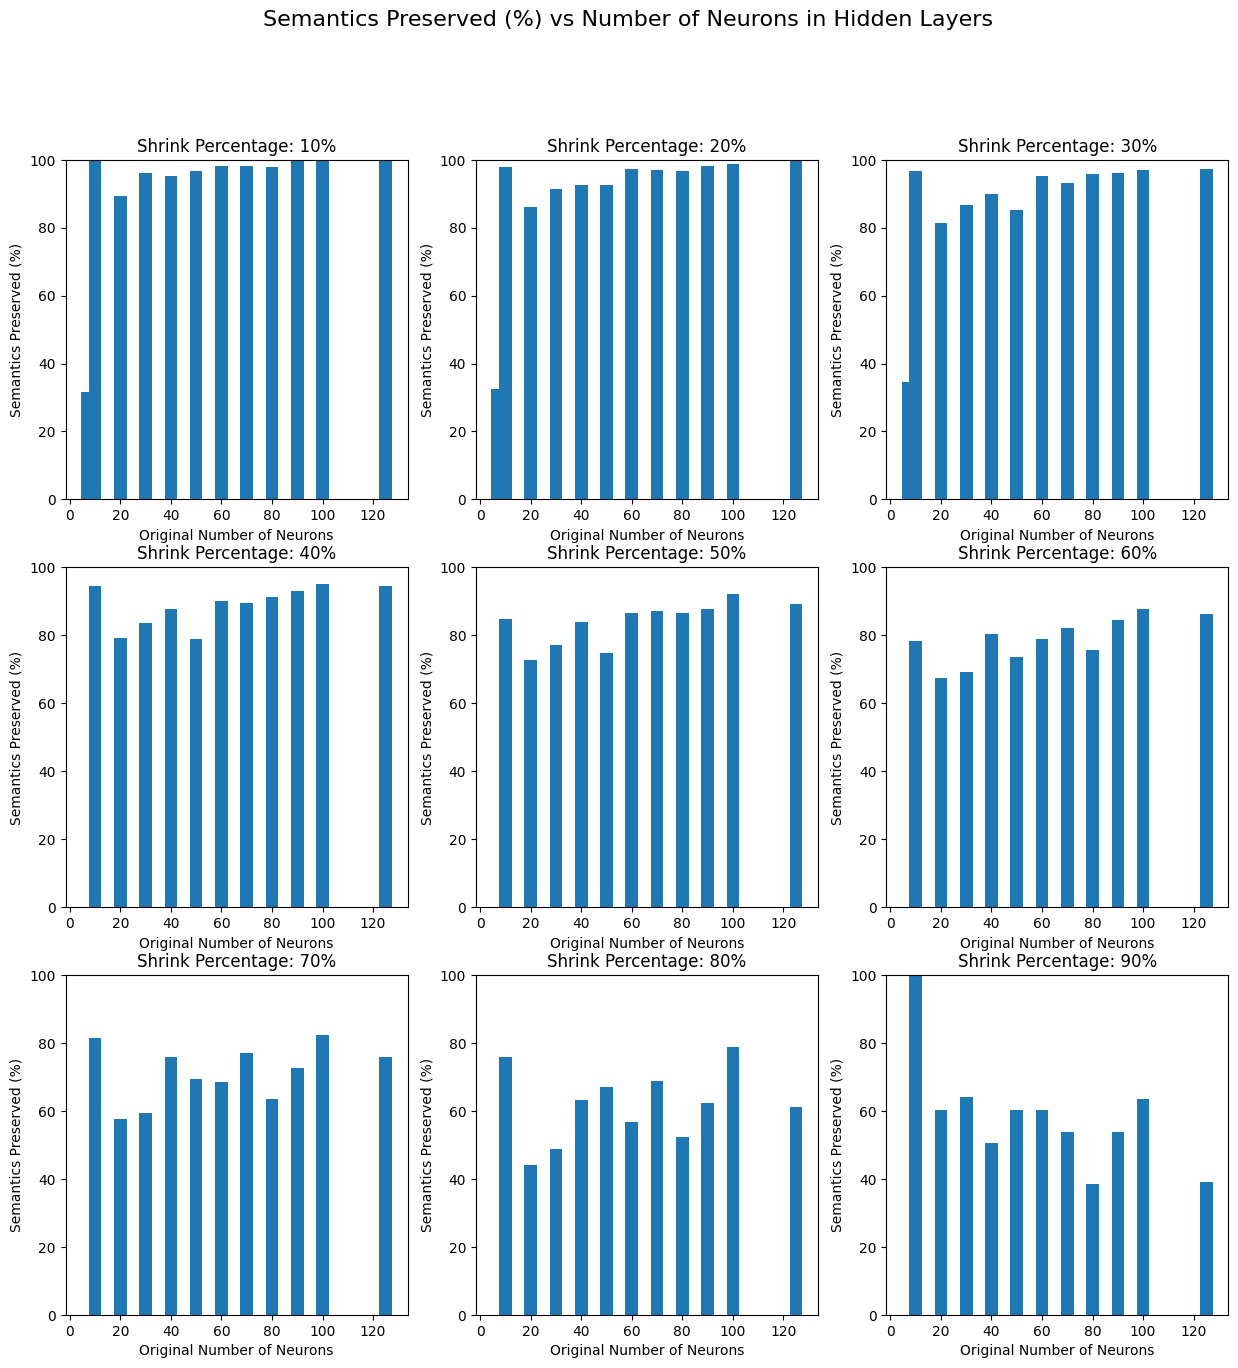

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 3, figsize=(15, 15))

totals_sorted_idx = np.argsort(totals)
totals_sorted = np.array(totals)[totals_sorted_idx]

for i, shrink_percentage in enumerate(shrink_percentages):

    percents = results_df.iloc[:, i+3].to_numpy()[totals_sorted_idx]
    
    ax[i//3, i%3].bar(totals_sorted, percents, width=5)
    # ax[i//3, i%3].plot(totals_sorted, percents, marker="o", color="red", linewidth=0.5, markersize=2)
    ax[i//3, i%3].set_title(f"Shrink Percentage: {shrink_percentage}%")
    ax[i//3, i%3].set_xlabel("Original Number of Neurons")
    ax[i//3, i%3].set_ylabel("Semantics Preserved (%)")
    ax[i//3, i%3].set_ylim(0, 100)

# fig.tight_layout()
fig.suptitle("Semantics Preserved (%) vs Number of Neurons in Hidden Layers", fontsize=16)
plt.show()


Further ideas:
<!-- - Track back the most important argument in the sparsifed network to see how much each of the input features contributed to this () -->
- Repeat using other types of AAE (e.g. removal scores)
- Repeat on other datasets, see if we get similar results (maybe later)
- Repeat this style of analysis on RAEs (time complexity issues for SHAP scores if MLPs are large)
- Start researching LRP to find some metrics to check faithfulness of explanations
    - Removal of neurons -> removing the most important neuron should have the biggest impact on the output
    - Perturbation of neurons -> perturbing the most important neuron should have the biggest impact on the output
    - Compare the faithfulness of the explanations before and after sparsification



- Coefficient $\checkmark$
- Ranking (weighting) -> score for cluster and original average
- AAEs
- Other AAE types

In [9]:
kendalltau_coeffs_dict = {}
spearman_coeffs_dict = {}

for mlp in gradient_scores_dict:
    kendalltau_coeffs = np.zeros(((gradient_scores_dict[mlp].shape[0], gradient_scores_dict[mlp].shape[1] - 1)), dtype=float)
    spearman_coeffs = np.zeros(((gradient_scores_dict[mlp].shape[0], gradient_scores_dict[mlp].shape[1] - 1)), dtype=float)
    top_scores = gradient_scores_dict[mlp]
    for example in range(top_scores.shape[0]):
        for sparse_percent in range(1, top_scores.shape[1]):
            kendalltau_coeffs[example, sparse_percent - 1] = kendalltau(np.abs(top_scores[example, 0]), np.abs(top_scores[example, sparse_percent]))[0]
            spearman_coeffs[example, sparse_percent - 1] = spearmanr(np.abs(top_scores[example, 0]), np.abs(top_scores[example, sparse_percent]))[0]

            # Deal with the case where the top scores are the same
            # If the top scores are all the same, then the correlation is 1
            # Otherwise, it is 0
            if np.isnan(kendalltau_coeffs[example, sparse_percent - 1]):
                if np.all(top_scores[example, 0] == top_scores[example, sparse_percent]):
                    kendalltau_coeffs[example, sparse_percent - 1] = 1.0
                else:
                    kendalltau_coeffs[example, sparse_percent - 1] = 0.0
            
            if np.isnan(spearman_coeffs[example, sparse_percent - 1]):
                if np.all(top_scores[example, 0] == top_scores[example, sparse_percent]):
                    spearman_coeffs[example, sparse_percent - 1] = 1.0
                else:
                    spearman_coeffs[example, sparse_percent - 1] = 0.0

    kendalltau_coeffs_dict[mlp] = kendalltau_coeffs
    spearman_coeffs_dict[mlp] = spearman_coeffs
    

/tmp/ipykernel_2706856/912873563.py:11: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_coeffs[example, sparse_percent - 1] = spearmanr(np.abs(top_scores[example, 0]), np.abs(top_scores[example, sparse_percent]))[0]


In [10]:

headers = ["MLP Shape", "Number of Neurons"] + [f"{percent}%" for percent in shrink_percentages]
kendalltaucoefficients_df = pd.DataFrame(columns=headers)

for mlp in kendalltau_coeffs_dict:
    hidden_layers = tuple(map(int, (mlp[3:].split("_"))))
    row = [hidden_layers, sum(hidden_layers)]
    row.extend(list(np.mean(kendalltau_coeffs_dict[mlp], axis=0)))
    kendalltaucoefficients_df.loc[len(kendalltaucoefficients_df)] = row

kendalltaucoefficients_df.sort_values("Number of Neurons", inplace=True)

In [11]:
kendalltaucoefficients_df.aggregate({h: ["mean", "max", "min"] for h in headers[2:]})

,10%,20%,30%,40%,50%,60%,70%,80%,90%
mean,0.83737,0.827083,0.823185,0.820097,0.816239,0.80984,0.806531,0.816768,0.848499
max,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000


In [12]:
headers = ["MLP Shape", "Number of Neurons"] + [f"{percent}%" for percent in shrink_percentages]
spearman_coefficients_df = pd.DataFrame(columns=headers)

for mlp in spearman_coeffs_dict:
    hidden_layers = tuple(map(int, (mlp[3:].split("_"))))
    row = [hidden_layers, sum(hidden_layers)]
    row.extend(list(np.mean(spearman_coeffs_dict[mlp], axis=0)))
    spearman_coefficients_df.loc[len(spearman_coefficients_df)] = row

spearman_coefficients_df.sort_values("Number of Neurons", inplace=True)

In [13]:
spearman_coefficients_df.aggregate({h: ["mean", "max", "min"] for h in headers[2:]})

,10%,20%,30%,40%,50%,60%,70%,80%,90%
mean,0.837444,0.827197,0.82328,0.820219,0.816498,0.810216,0.807154,0.817795,0.849445
max,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


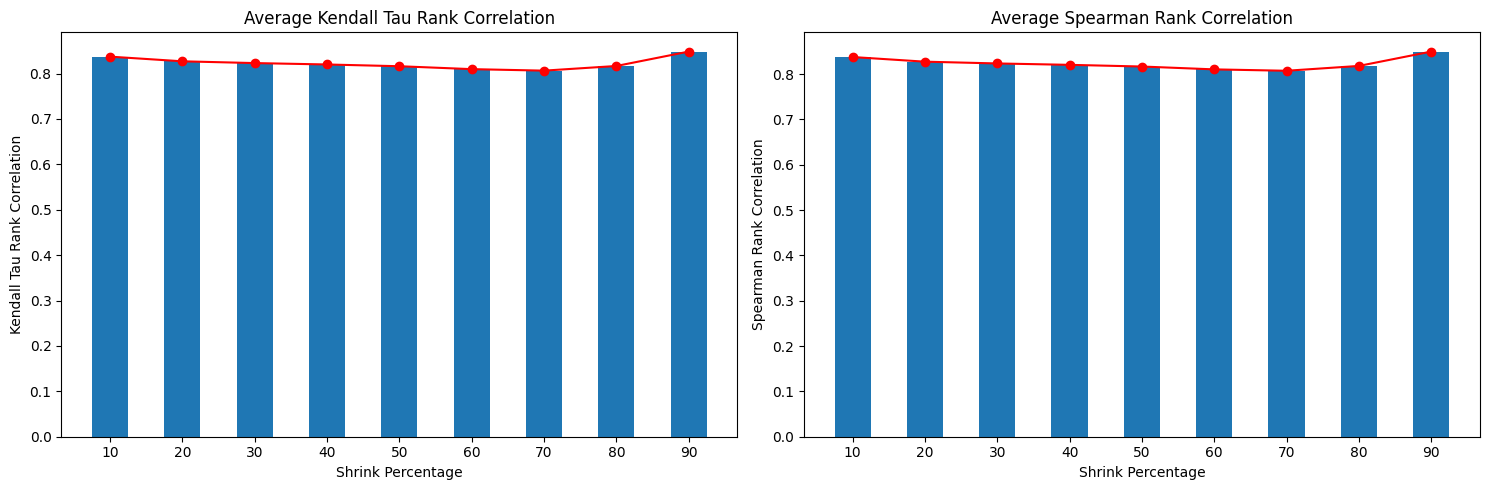

In [14]:
average_kendalltau_ranks = np.zeros((len(shrink_percentages)))

for mlp in kendalltau_coeffs_dict:
    average_kendalltau_ranks += np.mean(kendalltau_coeffs_dict[mlp], axis=0)

average_kendalltau_ranks /= len(kendalltau_coeffs_dict)

average_spearman_ranks = np.zeros((len(shrink_percentages)))

for mlp in spearman_coeffs_dict:
    average_spearman_ranks += np.mean(spearman_coeffs_dict[mlp], axis=0)

average_spearman_ranks /= len(spearman_coeffs_dict)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].bar(shrink_percentages, average_kendalltau_ranks, width=5)
ax[0].plot(shrink_percentages, average_kendalltau_ranks, marker="o", color="red")
ax[0].set_title("Average Kendall Tau Rank Correlation")
ax[0].set_xlabel("Shrink Percentage")
ax[0].set_ylabel("Kendall Tau Rank Correlation")
# ax[0].set_ylim(0, 1)
ax[0].set_xticks(shrink_percentages)
# ax[0].axhline(0, color="black")

ax[1].bar(shrink_percentages, average_spearman_ranks, width=5)
ax[1].plot(shrink_percentages, average_spearman_ranks, marker="o", color="red")
ax[1].set_title("Average Spearman Rank Correlation")
ax[1].set_xlabel("Shrink Percentage")
ax[1].set_ylabel("Spearman Rank Correlation")
# ax[1].set_ylim(0, 1)
ax[1].set_xticks(shrink_percentages)
plt.tight_layout()
plt.show()

In [15]:
shrink_percentages = [10, 20, 30, 40, 50, 60, 70, 80, 90]
top_n_same = np.zeros((len(rankings_dict), len(shrink_percentages)))
top_in_top_n = np.zeros((len(rankings_dict), len(shrink_percentages)))
pearson_coeffs = np.zeros((len(rankings_dict), len(shrink_percentages)))
kendalltau_coeffs = np.zeros((len(rankings_dict), len(shrink_percentages)))
rankings_diff = np.zeros((len(rankings_dict), len(shrink_percentages)))
for m, mlp in enumerate(rankings_dict):
    top_n_same_tmp = np.zeros((len(rankings_dict[mlp]), len(shrink_percentages))) 
    top_in_top_n_tmp = np.zeros((len(rankings_dict[mlp]), len(shrink_percentages)))
    pearson_coeffs_tmp = np.zeros((len(rankings_dict[mlp]), len(shrink_percentages)))
    kendalltau_coeffs_tmp = np.zeros((len(rankings_dict[mlp]), len(shrink_percentages)))
    rankings_diff_tmp = np.zeros((len(rankings_dict[mlp]), len(shrink_percentages)))
    for example in range(len(rankings_dict[mlp])):
        for sparse_percent in range(len(rankings_dict[mlp][example])):
            original_scores = rankings_dict[mlp][example][sparse_percent, 0]
            original_scores[:, 1] = np.abs(np.astype(original_scores[:, 1], float))
            sparse_scores = rankings_dict[mlp][example][sparse_percent, 1]
            sparse_scores[:, 1] = np.abs(np.astype(sparse_scores[:, 1], float))
            count_same_rankings = 0
            original_scores_sorted = np.array(sorted(original_scores, key=lambda x: float(x[1]), reverse=True))
            sparse_scores_sorted = np.array(sorted(sparse_scores, key=lambda x: float(x[1]), reverse=True))
            top_n = min(10, len(sparse_scores_sorted) // 2)
            for i in range(top_n):
                if original_scores_sorted[i, 0] in sparse_scores_sorted[:top_n, 0]:
                    count_same_rankings += 1
            top_n_same_tmp[example, sparse_percent] = count_same_rankings / top_n * 100

            if original_scores_sorted[0, 0] in sparse_scores_sorted[:top_n, 0]:
                top_in_top_n_tmp[example, sparse_percent] = 1
            
            for i in range(len(original_scores_sorted)):
                clustered_i = np.argwhere(sparse_scores_sorted[:, 0] == original_scores_sorted[i, 0])
                if len(clustered_i) == 0:
                    raise ValueError("Could not find the argument in the sparse scores")
                clustered_i = clustered_i[0][0]
                rankings_diff_tmp[example, sparse_percent] += abs(i - clustered_i) / len(original_scores_sorted) * 100
            
            rankings_diff_tmp[example, sparse_percent] /= len(original_scores_sorted)

            original_scores_sorted = np.array(sorted(original_scores, key=lambda x: x[1], reverse=True))
            sparse_scores_sorted = np.array(sorted(sparse_scores, key=lambda x: x[1], reverse=True))

            pearson_coeffs_tmp[example, sparse_percent] = spearmanr([float(x[1]) for x in original_scores_sorted], [float(x[1]) for x in sparse_scores_sorted])[0]
            kendalltau_coeffs_tmp[example, sparse_percent] = kendalltau([float(x[1]) for x in original_scores_sorted], [float(x[1]) for x in sparse_scores_sorted])[0]
    top_in_top_n[m] = np.mean(top_in_top_n_tmp, axis=0) * 100
    pearson_coeffs[m] = np.mean(pearson_coeffs_tmp, axis=0)
    top_n_same[m] = np.mean(top_n_same_tmp, axis=0)
    kendalltau_coeffs[m] = np.mean(kendalltau_coeffs_tmp, axis=0)
    rankings_diff[m] = np.mean(rankings_diff_tmp, axis=0)


/tmp/ipykernel_2706856/11805857.py:43: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_coeffs_tmp[example, sparse_percent] = spearmanr([float(x[1]) for x in original_scores_sorted], [float(x[1]) for x in sparse_scores_sorted])[0]


In [16]:
headers = ["MLP Shape", "Number of Neurons", "Number of Hidden Layers"] + [f"{percent}%" for percent in shrink_percentages]
top_n_same_df = pd.DataFrame(columns=headers)
top_n_same_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in rankings_dict]
top_n_same_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in rankings_dict]
top_n_same_df["Number of Hidden Layers"] = [len(x) for x in top_n_same_df["MLP Shape"]]
top_n_same_df[headers[3:]] = top_n_same
top_n_same_df.sort_values("Number of Neurons", inplace=True)

In [17]:
top_n_same_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})

,10%,20%,30%,40%,50%,60%,70%,80%,90%
mean,86.590909,82.003262,78.166671,74.923772,70.833804,67.300333,63.269608,59.053646,48.825582
max,98.354978,97.056277,95.584416,94.415584,92.424242,88.787879,84.329004,78.961039,67.662338
min,51.298701,44.199134,44.242424,47.272727,46.839827,40.865801,40.865801,40.649351,23.593074


In [18]:
rankings_diff_df = pd.DataFrame(columns=headers)
rankings_diff_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in rankings_dict]
rankings_diff_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in rankings_dict]
rankings_diff_df["Number of Hidden Layers"] = [len(x) for x in rankings_diff_df["MLP Shape"]]
rankings_diff_df[headers[3:]] = rankings_diff
rankings_diff_df.sort_values("Number of Neurons", inplace=True)


In [19]:
rankings_diff_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})

,10%,20%,30%,40%,50%,60%,70%,80%,90%
mean,5.893261,8.051289,10.220165,11.797941,13.603641,15.526775,18.501081,22.838803,31.317639
max,27.608289,27.577551,27.873978,34.238489,34.295732,37.974026,37.974026,37.974026,43.225910
min,2.540481,4.430465,6.487734,7.487193,7.392285,8.471997,9.750506,13.276467,21.254877


In [20]:
top_in_top_n_df = pd.DataFrame(columns=headers)
top_in_top_n_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in rankings_dict]
top_in_top_n_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in rankings_dict]
top_in_top_n_df["Number of Hidden Layers"] = [len(x) for x in top_in_top_n_df["MLP Shape"]]
top_in_top_n_df[headers[3:]] = top_in_top_n
top_in_top_n_df.sort_values("Number of Neurons", inplace=True)

In [21]:
top_in_top_n_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})

,10%,20%,30%,40%,50%,60%,70%,80%,90%
mean,97.590815,96.856766,95.896857,94.579334,93.901750,94.014681,91.981931,87.897610,76.077546
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,99.134199
min,56.277056,42.424242,43.290043,55.411255,55.411255,55.411255,55.411255,55.411255,0.000000


In [22]:
pearson_coeffs_df = pd.DataFrame(columns=headers)
pearson_coeffs_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in rankings_dict]
pearson_coeffs_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in rankings_dict]
pearson_coeffs_df["Number of Hidden Layers"] = [len(x) for x in pearson_coeffs_df["MLP Shape"]]
pearson_coeffs_df[headers[3:]] = pearson_coeffs
pearson_coeffs_df.sort_values("Number of Neurons", inplace=True)

In [23]:
pearson_coeffs_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})

,10%,20%,30%,40%,50%,60%,70%,80%,90%
mean,0.994632,0.992099,0.989063,0.987599,0.983901,0.977657,0.971924,0.967830,0.815711
max,0.998994,0.998546,0.998353,0.998259,0.998121,0.994875,1.000000,1.000000,1.000000
min,0.982246,0.969307,0.959997,0.962335,0.950261,0.893253,0.893253,0.893253,-0.563425


In [24]:
kendalltau_coeffs_df = pd.DataFrame(columns=headers)
kendalltau_coeffs_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in rankings_dict]
kendalltau_coeffs_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in rankings_dict]
kendalltau_coeffs_df["Number of Hidden Layers"] = [len(x) for x in kendalltau_coeffs_df["MLP Shape"]]
kendalltau_coeffs_df[headers[3:]] = kendalltau_coeffs
kendalltau_coeffs_df.sort_values("Number of Neurons", inplace=True)


In [25]:
kendalltau_coeffs_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})

,10%,20%,30%,40%,50%,60%,70%,80%,90%
mean,0.993931,0.992121,0.990063,0.989250,0.986902,0.982150,0.978183,0.975731,0.846665
max,0.998665,0.998198,0.998722,0.998715,0.998557,0.996312,1.000000,1.000000,1.000000
min,0.967563,0.971459,0.969885,0.971276,0.962653,0.920316,0.920316,0.920316,-0.206463


#### Creating a faithfulness score

In SpArX, evalaute faithfulness using a structural faithfulness score and input-output faithfuless. 

Do something similar by looking at the impact of removal of the most important argument on the strength of the topic argument. If the strength after removal is roughly the same in both then this shows the sparsification is faithful (similar to input/output faithfulness).

Structural faithfulness: Create a score based on how close the averaged rankings are to the sparse rankings -> large difference = lower structural faithfulness.

Next steps: Compare to ML methods -> just compute AAEs on input arguments

### RAEs Analysis

![RAE Illustration](RAE_Illustration.png)


In [26]:
rankings_dict = {}
rankings_variances_dict = {}
rankings_weighted_dict = {}
non_averaged_rankings_percents = {}
non_averaged_kendalltau_coeffs_dict = {}
non_averaged_pearson_coeffs_dict = {}

for mlp in Path("../../outputs/diabetes/rae").glob("*_shap.npz"):

    file_name = mlp.stem
    # mlp_size1_size2_size3..._gradient.npz
    mlp_size = file_name.replace("_shap","")
    print(mlp_size)

    data = np.load(mlp, allow_pickle=True)

    rankings_dict[mlp_size] = data["rankings"]

    try:
        non_averaged_rankings_percents[mlp_size] = data["non_averaged_rankings"]
        rankings_weighted_dict[mlp_size] = data["rankings_weighted"]
        rankings_variances_dict[mlp_size] = data["rankings_variances"]
        non_averaged_kendalltau_coeffs_dict[mlp_size] = data["kendall_taus"]
        non_averaged_pearson_coeffs_dict[mlp_size] = data["pearson_correlations"]
    except Exception:
        # Haven't been calculated yet
        continue

mlp3
mlp10_10
mlp5_10
mlp2_2
mlp4
mlp5_5
mlp3_50
mlp2
mlp3_3_3
mlp8_8
mlp6_6
mlp3_20
mlp5
mlp4_4
mlp9
mlp6
mlp2_40
mlp2_50
mlp3_3
mlp10_2
mlp2_20
mlp2_30
mlp10_5
mlp10
mlp2_10
mlp7_7
mlp7
mlp8
mlp9_9


In [27]:
def remove_relation_type(arr):
    for i in range(len(arr)):
        if "Attack" in arr[i]:
            arr[i] = arr[i].replace("Attack(", "").replace(")", "")
        else:
            arr[i] = arr[i].replace("Support(", "").replace(")", "")

    return arr 

shrink_percentages = [20, 40, 60, 80]
top_n_same = np.zeros((len(rankings_dict), len(shrink_percentages)))
top_in_top_n = np.zeros((len(rankings_dict), len(shrink_percentages)))
pearson_coeffs = np.zeros((len(rankings_dict), len(shrink_percentages)))
kendalltau_coeffs = np.zeros((len(rankings_dict), len(shrink_percentages)))
rankings_diff = np.zeros((len(rankings_dict), len(shrink_percentages)))
for m, mlp in enumerate(rankings_dict):
    top_n_same_tmp = np.zeros((len(rankings_dict[mlp]), len(shrink_percentages))) 
    top_in_top_n_tmp = np.zeros((len(rankings_dict[mlp]), len(shrink_percentages)))
    pearson_coeffs_tmp = np.zeros((len(rankings_dict[mlp]), len(shrink_percentages)))
    kendalltau_coeffs_tmp = np.zeros((len(rankings_dict[mlp]), len(shrink_percentages)))
    rankings_diff_tmp = np.zeros((len(rankings_dict[mlp]), len(shrink_percentages)))
    for example in range(len(rankings_dict[mlp])):
        for sparse_percent in range(len(rankings_dict[mlp][example])):
            original_scores = rankings_dict[mlp][example][sparse_percent, 0]
            original_scores[:, 1] = np.abs(np.astype(original_scores[:, 1], float))
            sparse_scores = rankings_dict[mlp][example][sparse_percent, 1]
            sparse_scores[:, 1] = np.abs(np.astype(sparse_scores[:, 1], float))
            sparse_scores[:, 0] = remove_relation_type(sparse_scores[:, 0])
            count_same_rankings = 0
            original_scores_sorted = np.array(sorted(original_scores, key=lambda x: float(x[1]), reverse=True))
            sparse_scores_sorted = np.array(sorted(sparse_scores, key=lambda x: float(x[1]), reverse=True))
            top_n = min(10, len(sparse_scores_sorted) // 2)
            for i in range(top_n):
                if original_scores_sorted[i, 0] in sparse_scores_sorted[:top_n, 0]:
                    count_same_rankings += 1
            top_n_same_tmp[example, sparse_percent] = count_same_rankings / top_n * 100

            if original_scores_sorted[0, 0] in sparse_scores_sorted[:top_n, 0]:
                top_in_top_n_tmp[example, sparse_percent] = 1
            
            for i in range(len(original_scores_sorted)):
                clustered_i = np.argwhere(sparse_scores_sorted[:, 0] == original_scores_sorted[i, 0])
                if len(clustered_i) == 0:
                    raise ValueError("Could not find the argument in the sparse scores")
                clustered_i = clustered_i[0][0]
                rankings_diff_tmp[example, sparse_percent] += abs(i - clustered_i) / len(original_scores_sorted) * 100
            
            rankings_diff_tmp[example, sparse_percent] /= len(original_scores_sorted)

            original_scores_sorted = np.array(sorted(original_scores, key=lambda x: x[1], reverse=True))
            sparse_scores_sorted = np.array(sorted(sparse_scores, key=lambda x: x[1], reverse=True))

            pearson_coeffs_tmp[example, sparse_percent] = spearmanr([float(x[1]) for x in original_scores_sorted], [float(x[1]) for x in sparse_scores_sorted])[0]
            kendalltau_coeffs_tmp[example, sparse_percent] = kendalltau([float(x[1]) for x in original_scores_sorted], [float(x[1]) for x in sparse_scores_sorted])[0]
    
    top_in_top_n[m] = np.mean(top_in_top_n_tmp, axis=0) * 100
    pearson_coeffs[m] = np.mean(pearson_coeffs_tmp, axis=0)
    top_n_same[m] = np.mean(top_n_same_tmp, axis=0)
    kendalltau_coeffs[m] = np.mean(kendalltau_coeffs_tmp, axis=0)
    rankings_diff[m] = np.mean(rankings_diff_tmp, axis=0)

Defining Preservation:
- Does the disribution of the RAEs stay the same? KL Divergence/ Wasserstein distance 
- Are the highest ranked relations the same? When the scores of the corresponding relations are averaged, do the top relations stay the same?

In [28]:
headers = ["MLP Shape", "Number of Neurons", "Number of Hidden Layers"] + [f"{percent}%" for percent in shrink_percentages]
top_n_same_df = pd.DataFrame(columns=headers)
top_n_same_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in rankings_dict]
top_n_same_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in rankings_dict]
top_n_same_df["Number of Hidden Layers"] = [len(x) for x in top_n_same_df["MLP Shape"]]
top_n_same_df[headers[3:]] = top_n_same
top_n_same_df.sort_values("Number of Neurons", inplace=True)

top_n_same_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})

,20%,40%,60%,80%
mean,24.693072,30.431988,39.837621,49.304788
max,62.987013,62.987013,62.987013,99.783550
min,6.060606,13.116883,20.389610,24.415584


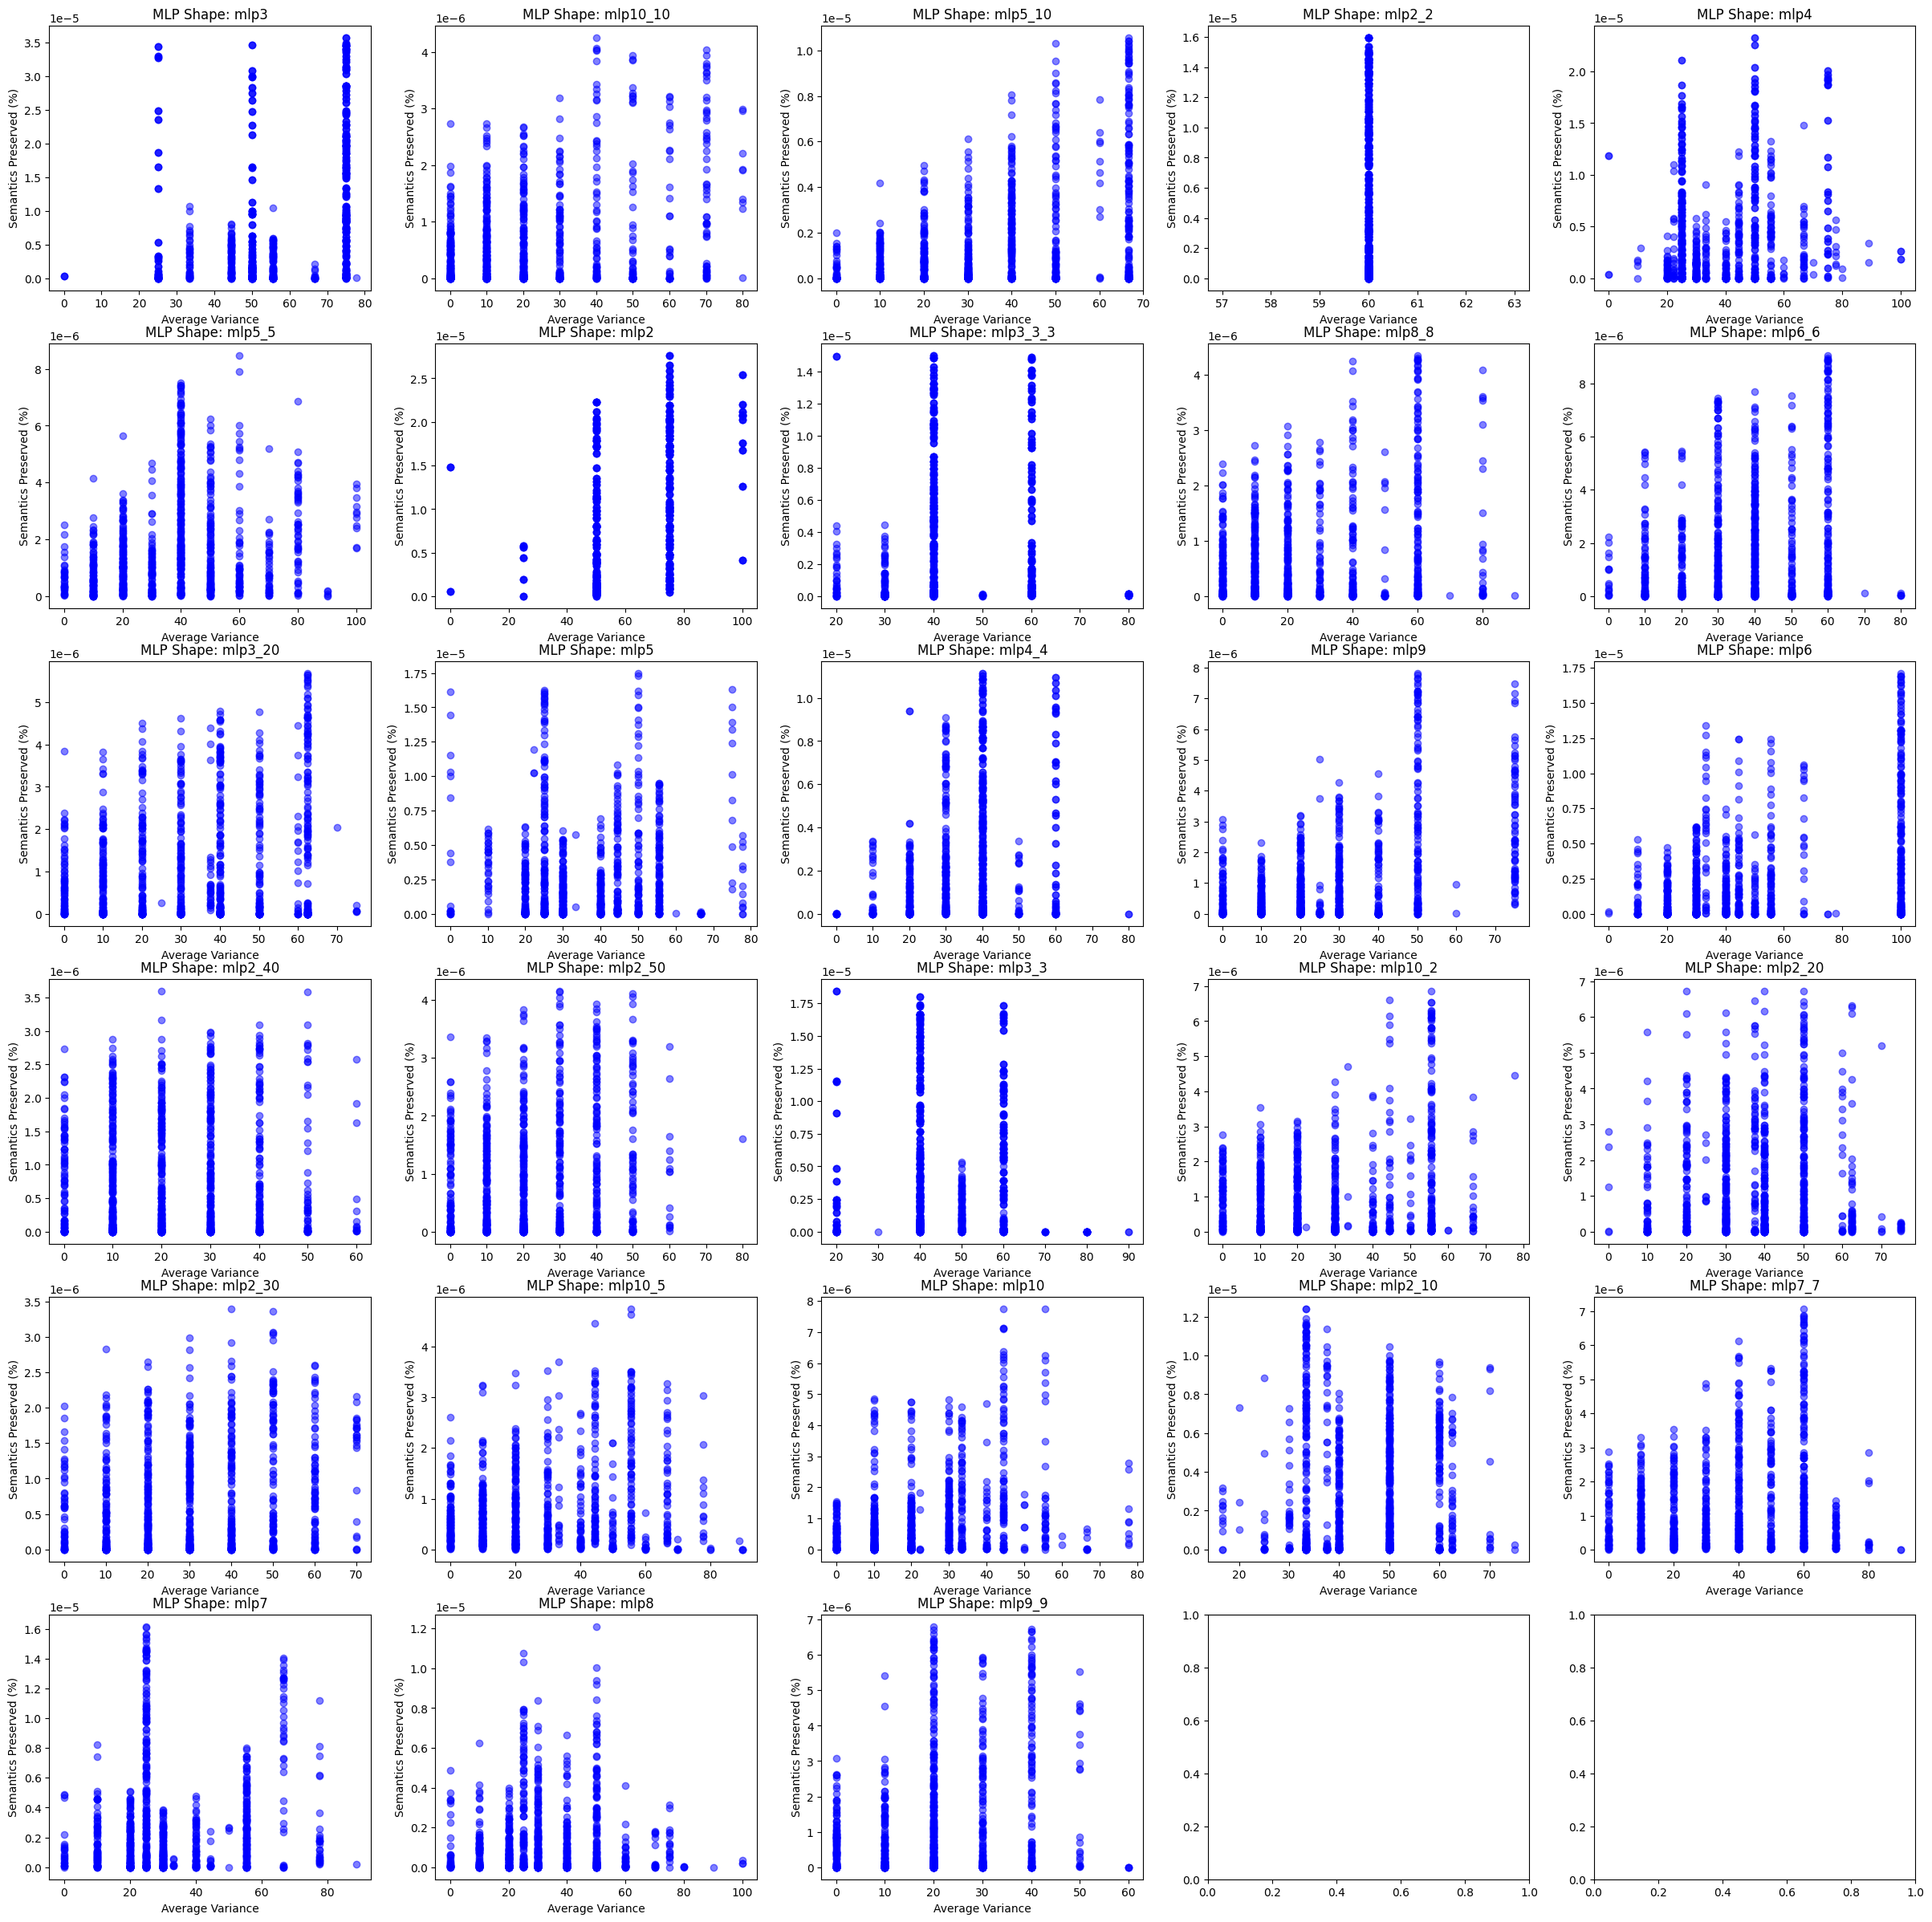

In [29]:
rows = math.ceil(math.sqrt(len(rankings_dict)))
cols = math.ceil(len(rankings_dict) / rows)

fig, ax = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))

mean_variances = np.zeros((len(rankings_variances_dict), len(shrink_percentages)))

for m, mlp in enumerate(rankings_variances_dict):
    var_dict_tmp = np.zeros((len(rankings_variances_dict[mlp]), len(shrink_percentages)))
    avg_variances = []
    avg_preservations = []
    for example in range(len(rankings_variances_dict[mlp])):
        for sparse_percent in range(len(rankings_variances_dict[mlp][example])):
            # Convert the data to float before calculating the mean
            variances = rankings_variances_dict[mlp][example][sparse_percent, 0][:, 1].astype(float)
            avg_variance = np.mean(variances)

            original_scores = rankings_dict[mlp][example][sparse_percent, 0]
            original_scores[:, 1] = np.abs(np.astype(original_scores[:, 1], float))
            sparse_scores = rankings_dict[mlp][example][sparse_percent, 1]
            sparse_scores[:, 1] = np.abs(np.astype(sparse_scores[:, 1], float))
            sparse_scores[:, 0] = remove_relation_type(sparse_scores[:, 0])
            count_same_rankings = 0
            original_scores_sorted = np.array(sorted(original_scores, key=lambda x: float(x[1]), reverse=True))
            sparse_scores_sorted = np.array(sorted(sparse_scores, key=lambda x: float(x[1]), reverse=True))
            top_n = min(10, len(sparse_scores_sorted) // 2)
            for i in range(top_n):
                if original_scores_sorted[i, 0] in sparse_scores_sorted[:top_n, 0]:
                    count_same_rankings += 1

            preservation = count_same_rankings / top_n * 100

            avg_variances.append(avg_variance)
            avg_preservations.append(preservation)

            var_dict_tmp[example, sparse_percent] = avg_variance
    
    mean_variances[m] = np.mean(var_dict_tmp, axis=0)

    ax[m//cols, m%cols].scatter(avg_preservations, avg_variances, color="blue", alpha=0.5)
    ax[m//cols, m%cols].set_title(f"MLP Shape: {mlp}")
    ax[m//cols, m%cols].set_xlabel("Average Variance")
    ax[m//cols, m%cols].set_ylabel("Semantics Preserved (%)")
    # ax[m//cols, m%cols].set_ylim(0, 100)
            
plt.show()

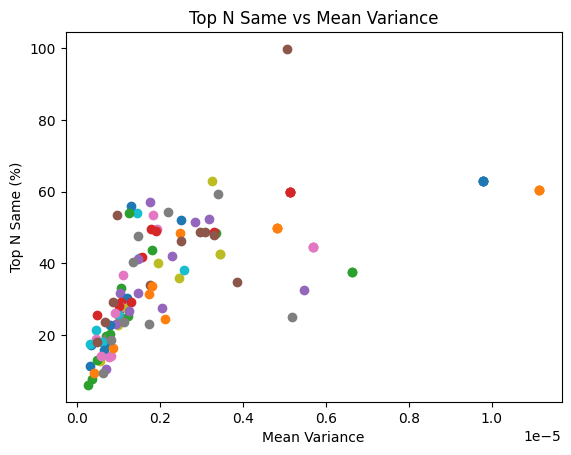

In [30]:
headers = ["MLP Shape", "Number of Neurons", "Number of Hidden Layers"] + [f"{percent}%" for percent in shrink_percentages]
rankings_variances_df = pd.DataFrame(columns=headers)
rankings_variances_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in rankings_variances_dict]
rankings_variances_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in rankings_variances_dict]
rankings_variances_df["Number of Hidden Layers"] = [len(x) for x in rankings_variances_df["MLP Shape"]]
rankings_variances_df[headers[3:]] = mean_variances
rankings_variances_df.sort_values("Number of Neurons", inplace=True)

for mlp in rankings_variances_df["MLP Shape"]:
    
    plt.scatter(rankings_variances_df[rankings_variances_df["MLP Shape"] == mlp].iloc[:, 3:].to_numpy()[0], top_n_same_df[top_n_same_df["MLP Shape"] == mlp].iloc[:, 3:].to_numpy()[0])


plt.xlabel("Mean Variance")
plt.ylabel("Top N Same (%)")
plt.title("Top N Same vs Mean Variance")

plt.show()

In [31]:
rankings_diff_df = pd.DataFrame(columns=headers)
rankings_diff_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in rankings_dict]
rankings_diff_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in rankings_dict]
rankings_diff_df["Number of Hidden Layers"] = [len(x) for x in rankings_diff_df["MLP Shape"]]
rankings_diff_df[headers[3:]] = rankings_diff
rankings_diff_df.sort_values("Number of Neurons", inplace=True)

rankings_diff_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})


,20%,40%,60%,80%
mean,31.892776,32.233213,32.039722,31.942037
max,36.472530,37.860899,35.989768,45.298701
min,20.351665,20.351665,20.351665,17.925285


In [32]:
top_in_top_n_df = pd.DataFrame(columns=headers)
top_in_top_n_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in rankings_dict]
top_in_top_n_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in rankings_dict]
top_in_top_n_df["Number of Hidden Layers"] = [len(x) for x in top_in_top_n_df["MLP Shape"]]
top_in_top_n_df[headers[3:]] = top_in_top_n
top_in_top_n_df.sort_values("Number of Neurons", inplace=True)

top_in_top_n_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})

,20%,40%,60%,80%
mean,23.525899,33.139275,40.812062,48.081803
max,99.134199,99.134199,99.134199,99.134199
min,0.000000,4.329004,6.493506,0.432900


In [33]:
pearson_coeffs_df = pd.DataFrame(columns=headers)
pearson_coeffs_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in rankings_dict]
pearson_coeffs_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in rankings_dict]
pearson_coeffs_df["Number of Hidden Layers"] = [len(x) for x in pearson_coeffs_df["MLP Shape"]]
pearson_coeffs_df[headers[3:]] = pearson_coeffs
pearson_coeffs_df.sort_values("Number of Neurons", inplace=True)

pearson_coeffs_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})

,20%,40%,60%,80%
mean,0.887777,0.832621,0.793366,0.696790
max,0.999895,1.000000,0.999935,0.999982
min,0.349312,-0.060181,-0.060181,-0.159998


In [34]:
kendalltau_coeffs_df = pd.DataFrame(columns=headers)
kendalltau_coeffs_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in rankings_dict]
kendalltau_coeffs_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in rankings_dict]
kendalltau_coeffs_df["Number of Hidden Layers"] = [len(x) for x in kendalltau_coeffs_df["MLP Shape"]]
kendalltau_coeffs_df[headers[3:]] = kendalltau_coeffs
kendalltau_coeffs_df.sort_values("Number of Neurons", inplace=True)

kendalltau_coeffs_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})

,20%,40%,60%,80%
mean,0.917479,0.872974,0.839687,0.760833
max,0.999613,0.999996,0.999613,0.999939
min,0.558231,0.111073,0.101410,0.033256


In [35]:
average_top_same_df = pd.DataFrame(columns=headers)
average_top_same_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in non_averaged_rankings_percents]
average_top_same_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in non_averaged_rankings_percents]
average_top_same_df["Number of Hidden Layers"] = [len(x) for x in average_top_same_df["MLP Shape"]]
average_top_same_df[headers[3:]] = [np.mean(non_averaged_rankings_percents[x], axis=0) for x in non_averaged_rankings_percents]
average_top_same_df.sort_values("Number of Neurons", inplace=True)

average_top_same_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})

,20%,40%,60%,80%
mean,9.355045,6.824277,10.12857,13.104467
max,49.567100,49.567100,49.56710,49.783550
min,0.000000,0.000000,0.00000,0.000000


In [36]:
non_averaged_kendall = np.zeros((len(non_averaged_kendalltau_coeffs_dict), len(shrink_percentages)))

for m, mlp in enumerate(non_averaged_kendalltau_coeffs_dict):

    non_averaged_kendall[m] = np.mean(non_averaged_kendalltau_coeffs_dict[mlp].squeeze(), axis=0)

non_averaged_kendall_df = pd.DataFrame(columns=headers)
non_averaged_kendall_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in non_averaged_kendalltau_coeffs_dict]
non_averaged_kendall_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in non_averaged_kendalltau_coeffs_dict]
non_averaged_kendall_df["Number of Hidden Layers"] = [len(x) for x in non_averaged_kendall_df["MLP Shape"]]
non_averaged_kendall_df[headers[3:]] = non_averaged_kendall
non_averaged_kendall_df.sort_values("Number of Neurons", inplace=True)

In [37]:
non_averaged_kendall_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})

,20%,40%,60%,80%
mean,0.987054,0.979840,0.967752,0.938840
max,0.996051,0.992375,0.984189,0.967505
min,0.946825,0.947214,0.932467,0.867499


In [38]:
non_averaged_pearson = np.zeros((len(non_averaged_pearson_coeffs_dict), len(shrink_percentages)))

for m, mlp in enumerate(non_averaged_pearson_coeffs_dict):
    non_averaged_pearson[m] = np.mean(non_averaged_pearson_coeffs_dict[mlp].squeeze(), axis=0)

non_averaged_pearson_df = pd.DataFrame(columns=headers)
non_averaged_pearson_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in non_averaged_pearson_coeffs_dict]
non_averaged_pearson_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in non_averaged_pearson_coeffs_dict]
non_averaged_pearson_df["Number of Hidden Layers"] = [len(x) for x in non_averaged_pearson_df["MLP Shape"]]
non_averaged_pearson_df[headers[3:]] = non_averaged_pearson
non_averaged_pearson_df.sort_values("Number of Neurons", inplace=True)

In [39]:
non_averaged_pearson_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})

,20%,40%,60%,80%
mean,0.902516,0.856927,0.807674,0.715558
max,0.986545,0.976789,0.969485,0.966699
min,0.416155,0.411125,0.397179,0.390652
